In [6]:
import os
import ast
import pandas as pd
import re
import matplotlib.pyplot as plt

In [337]:
# Define directory where the txt files are located
dir_path = 'tablet2\save'

# Define function to clean lists in dataframe
def clean_df(df, column, new_columns):
    ref_list = [0, 0]
    for i, row in df.iterrows():
        if len(row[column]) == 2:
            ref_list = row[column]
        df.at[i, column] = ref_list if len(row[column]) != 2 else row[column]
    df = pd.concat([df, pd.DataFrame(df[column].to_list(), columns=new_columns, index=df.index)], axis=1)
    df = df.drop(columns=[column])
    return df

# Define function to remove duplicate rows based on certain columns
def remove_duplicates(df, columns):
    prev_values = [None, None]
    rows_to_remove = []
    for index, row in df.iterrows():
        values = [row[columns[0]], row[columns[1]]]
        if values == prev_values:
            rows_to_remove.append(index)
        prev_values = values
    df = df.drop(rows_to_remove)
    return df.reset_index(drop=True)

# Define function to create dataframe from certain files
def create_df(df_names_list, dir_path, filename_structure, new_data_columns):
    dfs = {name: None for name in df_names_list}
    for name in df_names_list:
        filename = f"{filename_structure} {name.replace(' ', ' ')}.txt"
        try:
            with open(os.path.join(dir_path, filename), 'r') as file:
                lines = file.readlines()
            if len(lines) == 0:
                continue
            new_data = {column: [] for column in new_data_columns}
            for line in lines:
                try:
                    row_data = ast.literal_eval(line.strip())
                    timestamp = pd.Timestamp(row_data[0]).strftime('%H:%M:%S.%f')[:-3]
                    new_data['timestamp'].append(timestamp)
                    values = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row_data[1])
                    if len(values) == 2:
                        new_data[new_data_columns[1]].append(float(values[0]))
                        new_data[new_data_columns[2]].append(float(values[1]))
                    else:
                        print(f"Unexpected data in file {filename}: {line}")
                except ValueError:
                    print(f"Error parsing line in file {filename}: {line}")
                    continue
            new_df = pd.DataFrame(new_data)
            dfs[name] = new_df
        except FileNotFoundError:
            print(f"File {filename} not found.")
    return dfs

# Get list of all txt files in the directory
txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt') and '1 modules' not in f]

# Initialize an empty dictionary to store the dataframes
dfs = {}

# Iterate over each txt file
for txt_file in txt_files:
    with open(os.path.join(dir_path, txt_file), 'r') as file:
        lines = file.readlines()
        
    if len(lines) <= 50:
        continue

    data = {name.strip(): [] for name in lines[0].replace('[', '').replace(']', '').split(',')}
    for line in lines[1:]:
        if "STOP" in line:
            break
        try:
            row_data = ast.literal_eval(line)
        except ValueError:
            print(f"Error parsing line in file {txt_file}: {line}")
            continue
        for name, value in zip(data.keys(), row_data):
            data[name].append(value)
   
    df = pd.DataFrame(data)
    df.columns = [col.strip("''") for col in df.columns]
    df['amplitudes'] = df['amplitudes'].apply(ast.literal_eval)
    df['offsets'] = df['offsets'].apply(ast.literal_eval)
    df['phase_biases'] = df['phase_biases'].apply(lambda x: ast.literal_eval(x)[0] if ast.literal_eval(x) else None)
    df['phase_biases'] = pd.to_numeric(df['phase_biases'])
    df = clean_df(df, 'amplitudes', ['amplitude_1', 'amplitude_2'])
    df = clean_df(df, 'offsets', ['offset_1', 'offset_2'])

    key = txt_file.replace('parameters ', '').replace('.txt', '')
    dfs[key] = df

oscillator_dir_path = 'tablet2\save\oscillator'
df_names_list = list(dfs.keys())

angle_dfs = create_df(df_names_list, oscillator_dir_path, 'angles', ['timestamp', 'angle_1', 'angle_2'])
for df_name in df_names_list:
    angle_dfs[df_name] = remove_duplicates(angle_dfs[df_name], ['angle_1', 'angle_2'])

potentials_dfs = create_df(df_names_list, oscillator_dir_path, 'potentials', ['timestamp', 'potentials_1', 'potentials_2'])
for df_name in df_names_list:
    potentials_dfs[df_name] = remove_duplicates(potentials_dfs[df_name], ['potentials_1', 'potentials_2'])


In [338]:
merged_dfs = {}

for df_name in df_names_list:
    # Make sure both dataframes exist
    if df_name in angle_dfs and df_name in potentials_dfs:
        angle_df = angle_dfs[df_name]
        potentials_df = potentials_dfs[df_name]
        
        # Merge the dataframes on 'timestamp'
        merged_df = pd.merge(angle_df, potentials_df, on='timestamp', how='outer')
        merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')
        
        # Store the merged dataframe in the dictionary
        merged_dfs[df_name] = merged_df

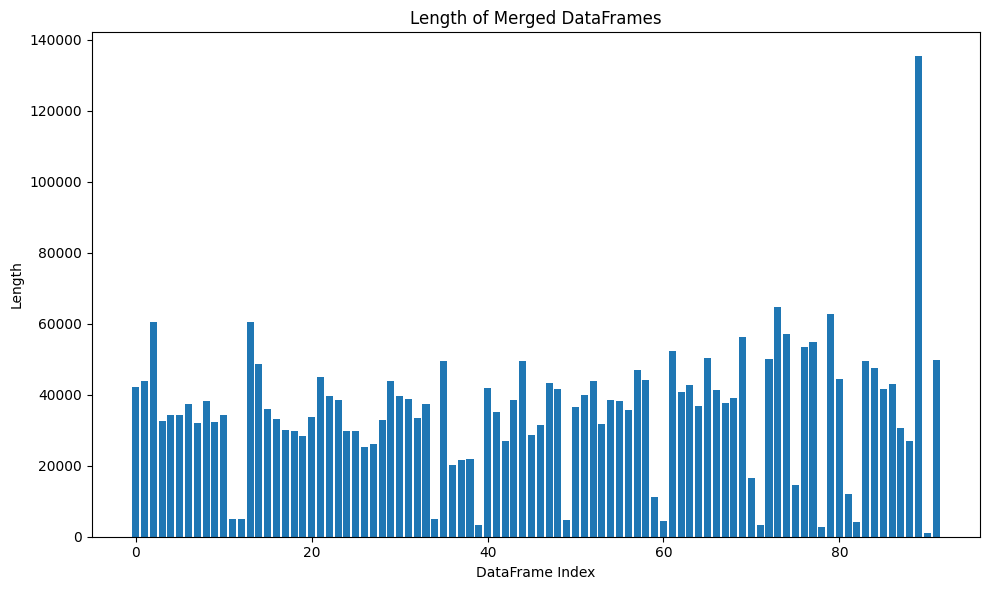

In [340]:
import matplotlib.pyplot as plt

lengths = [len(value) for value in merged_dfs.values()]
indices = list(range(0, len(lengths)))  

plt.figure(figsize=(10, 6))  
plt.bar(indices, lengths)
plt.xlabel('DataFrame Index')
plt.ylabel('Length')
plt.title('Length of Merged DataFrames')
plt.tight_layout()  
plt.show()


In [341]:
def create_imu_df(df_names_list, dir_path, filename_structure):
    dfs = {name: None for name in df_names_list}
    for name in df_names_list:
        filename = f"{filename_structure} {name.replace(' ', ' ')}.txt"
        try:
            with open(os.path.join(dir_path, filename), 'r') as file:
                lines = file.readlines()
            if len(lines) == 0:
                continue
            new_data = {column: [] for column in ast.literal_eval(lines[0])}
            for line in lines[1:]:  # start from 1 to skip the header
                try:
                    row_data = ast.literal_eval(line.strip())
                    for column, value in zip(new_data.keys(), row_data):
                        new_data[column].append(value)
                except ValueError:
                    print(f"Error parsing line in file {filename}: {line}")
                    continue
            new_df = pd.DataFrame(new_data)
            new_df = remove_duplicates(new_df, new_df.columns.tolist())  # use all columns to find duplicates
            dfs[name] = new_df
        except FileNotFoundError:
            print(f"File {filename} not found.")
    return dfs

imu_dfs = create_imu_df(df_names_list, oscillator_dir_path, 'imu')


In [342]:
%store angle_dfs dfs potentials_dfs merged_dfs df_names_list imu_dfs

Stored 'angle_dfs' (dict)
Stored 'dfs' (dict)
Stored 'potentials_dfs' (dict)
Stored 'merged_dfs' (dict)
Stored 'df_names_list' (list)
Stored 'imu_dfs' (dict)


In [4]:
%store -r angle_dfs dfs potentials_dfs merged_dfs df_names_list imu_dfs params_oscills_dfs

In [162]:
params_oscills_dfs = {}

for df_name in df_names_list:
    # Make sure both dataframes exist
    if df_name in dfs and df_name in merged_dfs:
        df = dfs[df_name]
        merged_df = merged_dfs[df_name]
        
        # Merge the dataframes on 'timestamp'
        params_oscills_df = pd.merge(df, merged_df, on='timestamp', how='outer')
        params_oscills_df = params_oscills_df.fillna(method='ffill').fillna(method='bfill')
        
        # Store the merged dataframe in the dictionary
        params_oscills_dfs[df_name] = params_oscills_df

In [8]:
def clean_dfs(df_dict):
    for key in df_dict.keys():
        df = df_dict[key]

        # Convert 'frequency' to a numeric type
        df['frequency'] = pd.to_numeric(df['frequency'], errors='coerce')

        # Drop rows that are identical to the preceding one
        df.drop_duplicates(inplace=True)

        # Group by timestamp and calculate mean
        df = df.groupby('timestamp').mean().reset_index()

        # Replace the old DataFrame with the cleaned one
        df_dict[key] = df

    return df_dict

params_oscills_dfs = clean_dfs(params_oscills_dfs)


In [9]:
%store params_oscills_dfs

Stored 'params_oscills_dfs' (dict)


In [81]:
%store -r params_oscills_dfs

In [346]:
len(params_oscills_dfs)

92

In [35]:
df_names_list[50]

'13-06-2023 09-03-11 401 2 modules'

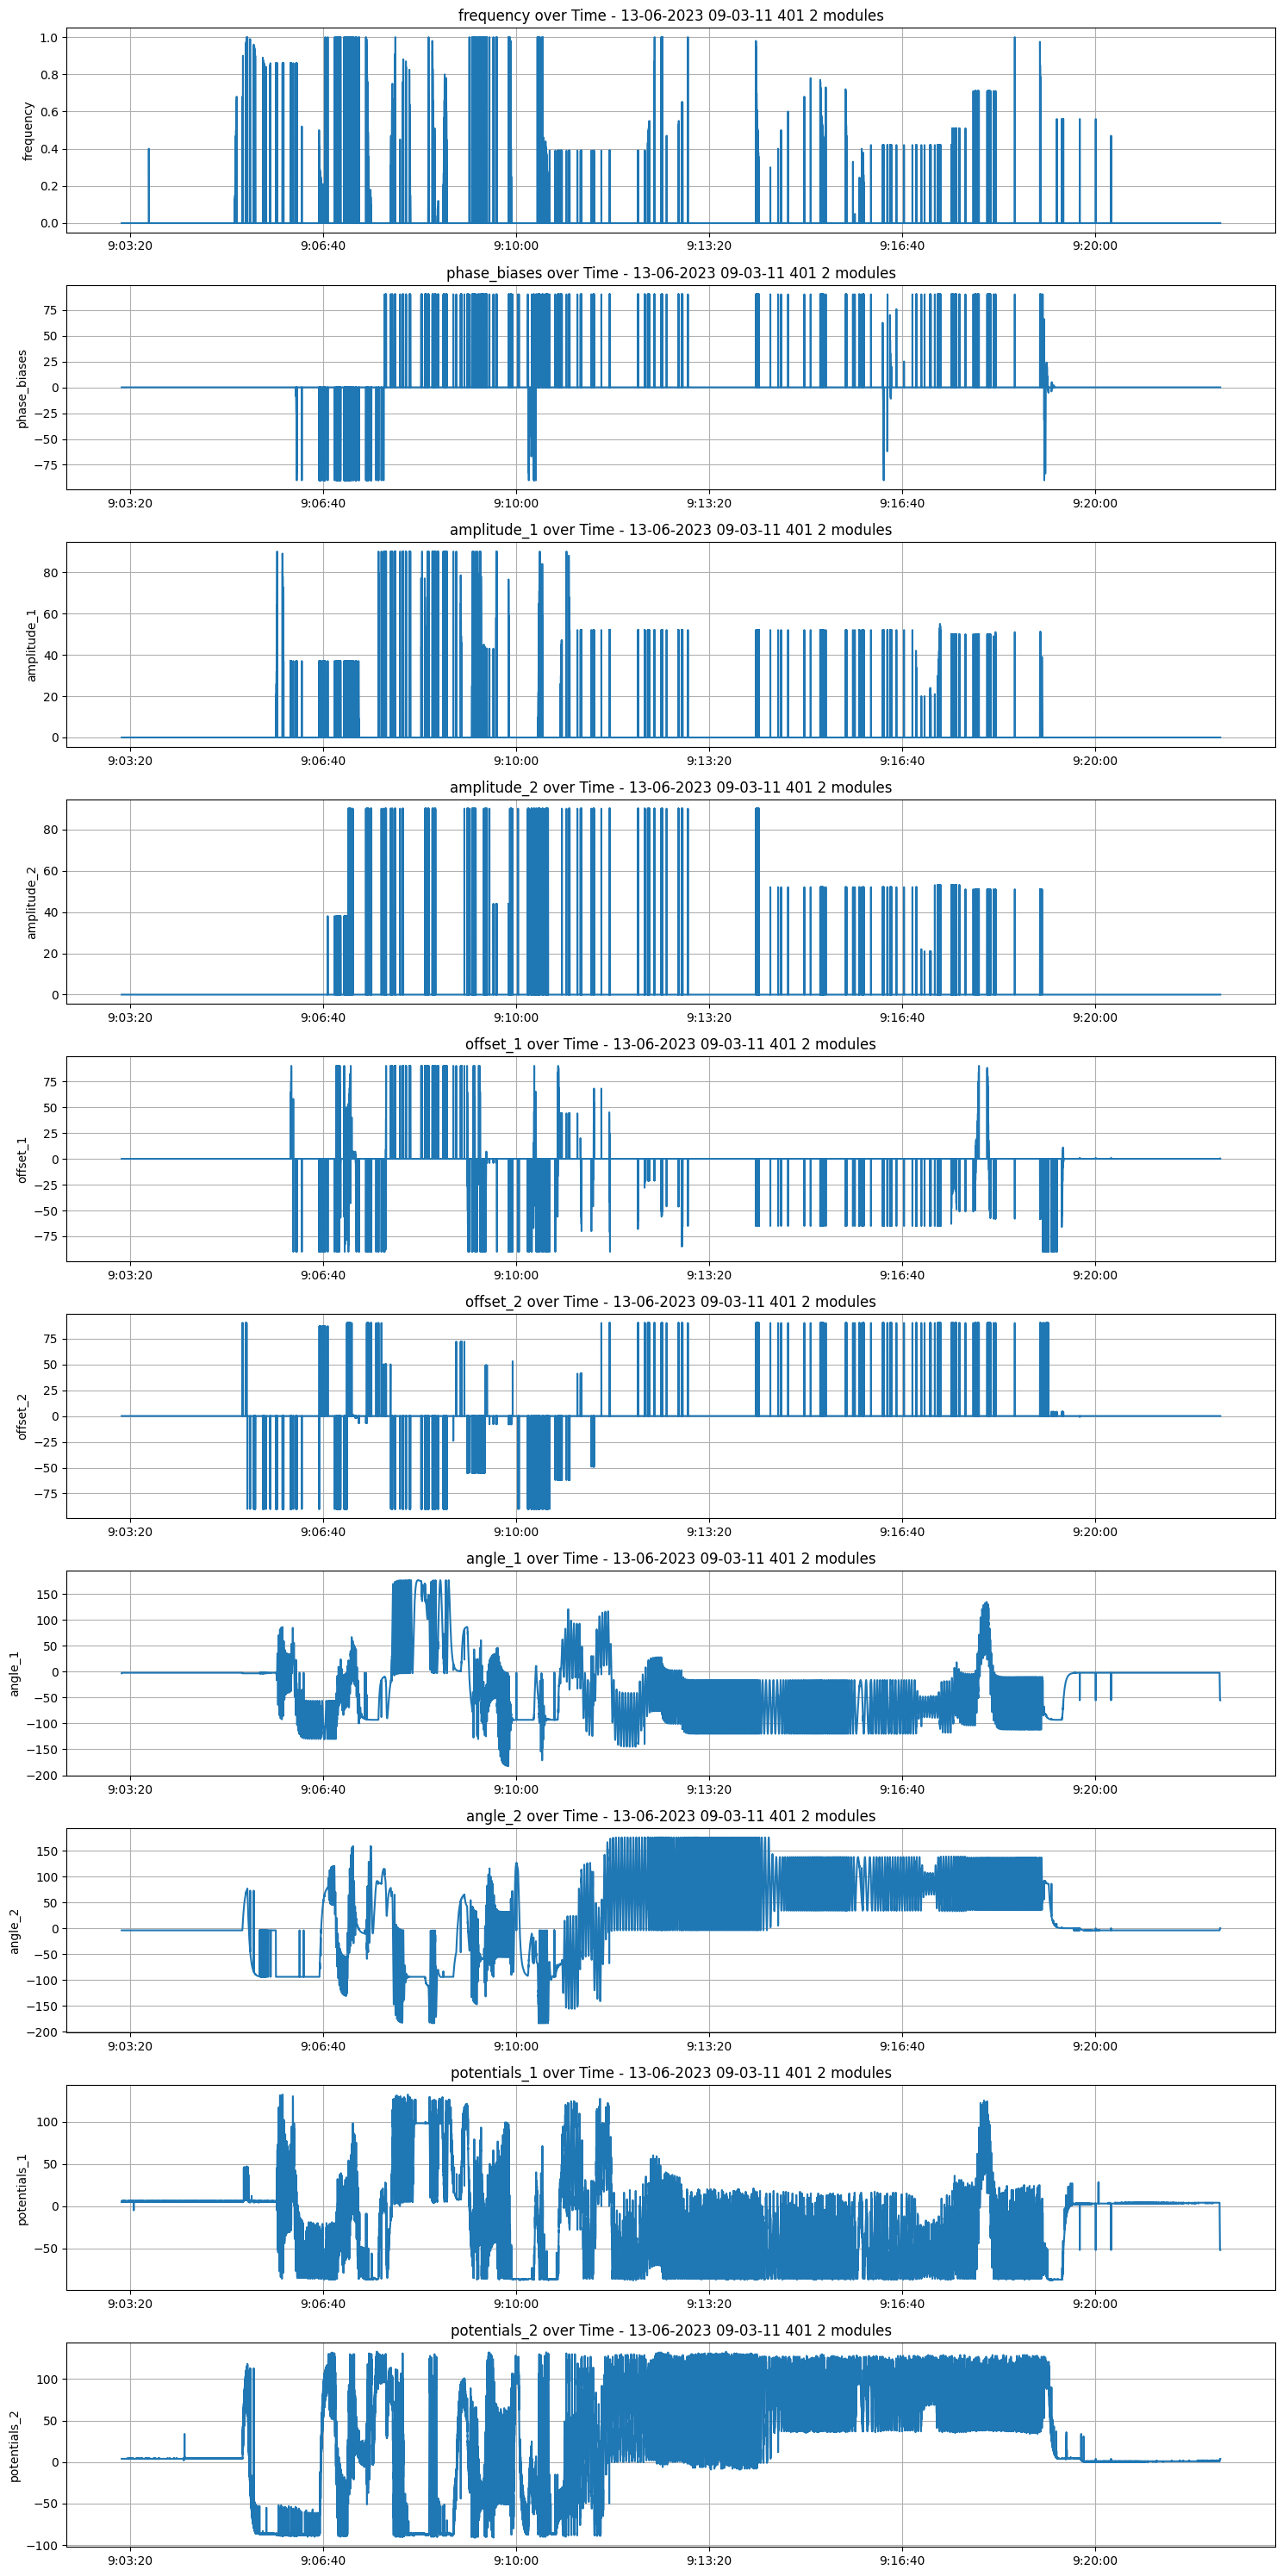

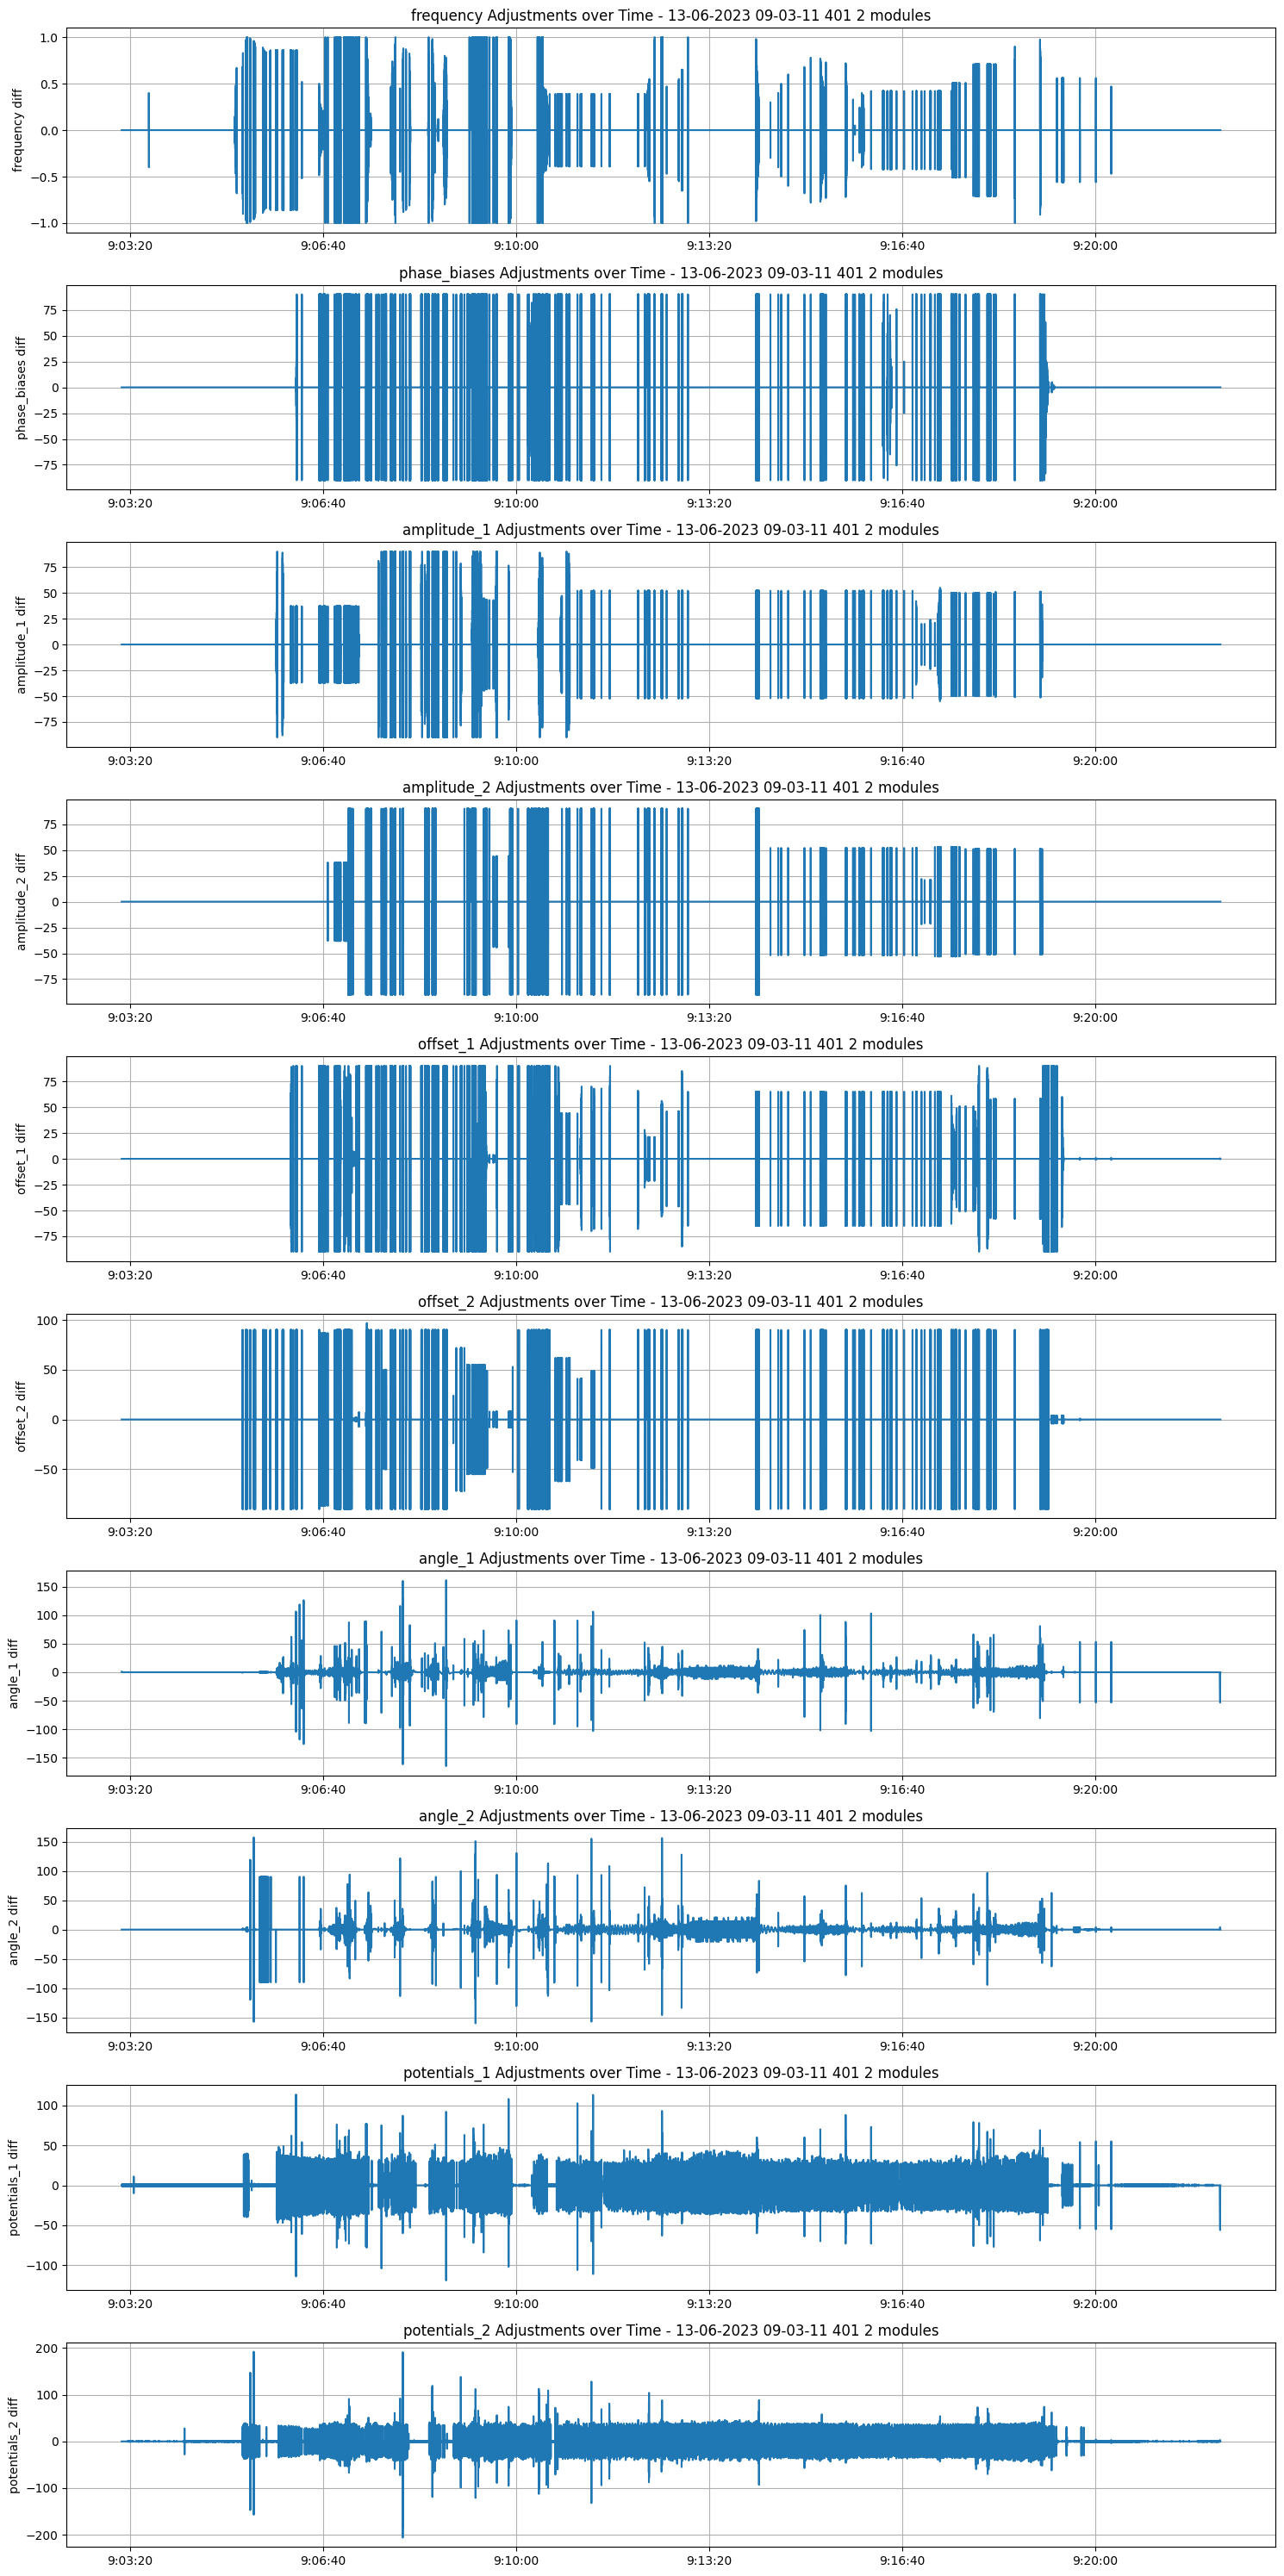

In [36]:
plot_parameters(50, df_names_list, params_oscills_dfs)

In [10]:
import seaborn as sns

def plot_correlations(position, df_list, df_dict):
    
    df_name = df_list[position]
    df = df_dict[df_name]

    
    correlation_matrix = df.corr()
    
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation_matrix, annot=True, square=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation matrix of parameters - {df_name}')
    plt.show()

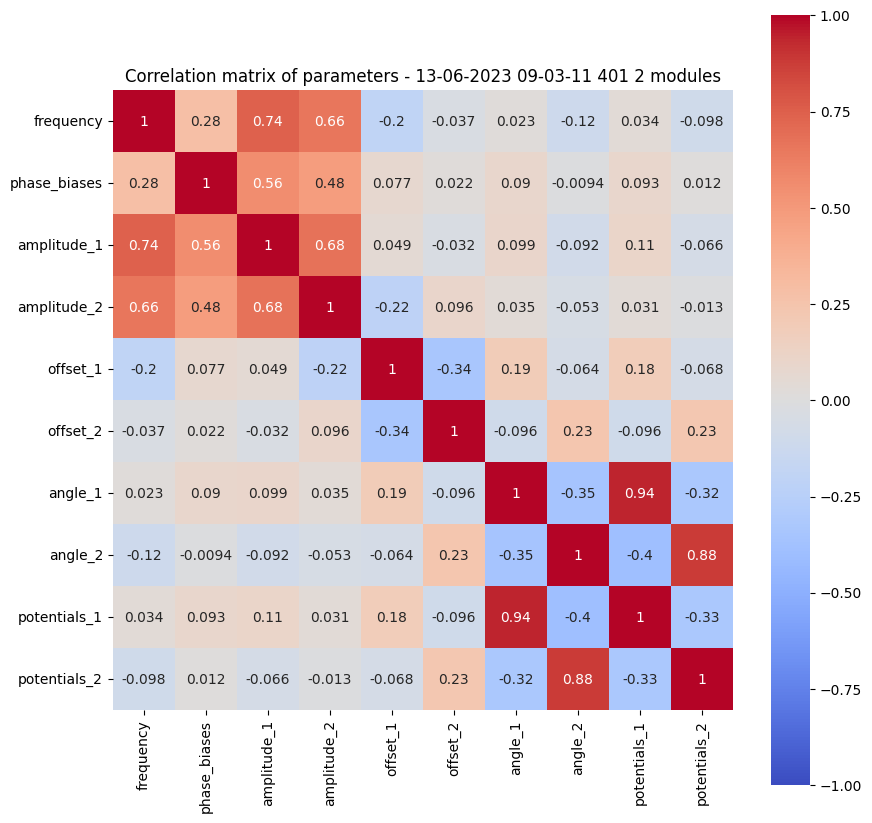

In [11]:
plot_correlations(50, df_names_list, params_oscills_dfs)

In [268]:
params_oscills_dfs[df_names_list[0]]

,timestamp,frequency,phase_biases,amplitude_1,amplitude_2,offset_1,offset_2,angle_1,angle_2,potentials_1,potentials_2
0,09:21:44.929,0.07,0.0,0.0,0.0,0.0,0.0,-2.78,-4.0,5.0,5.0
1,09:21:45.479,0.0,0.0,0.0,0.0,0.0,0.0,-2.78,-4.0,5.0,5.0
2,09:25:06.992,0.02,0.0,0.0,0.0,0.0,0.0,-2.78,-4.0,5.0,5.0
3,09:25:07.086,0.03,0.0,0.0,0.0,0.0,0.0,-2.78,-4.0,5.0,5.0
4,09:25:07.179,0.04,0.0,0.0,0.0,0.0,0.0,-2.78,-4.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
43861,09:44:27.550,0.0,0.0,0.0,0.0,0.0,0.0,-4.00,-1.0,2.0,5.0
43862,09:44:27.581,0.0,0.0,0.0,0.0,0.0,0.0,-4.00,-1.0,3.0,5.0
43863,09:44:27.769,0.0,0.0,0.0,0.0,0.0,0.0,-4.00,-1.0,2.0,5.0
43864,09:44:27.800,0.0,0.0,0.0,0.0,0.0,0.0,-4.00,-1.0,3.0,5.0


In [289]:
individual_child_dfs = {}
for session in df_names_list:
    # Load the session data
    session_df = dfs[session]

    # Identify the columns specific to each child
    child_1_cols = [col for col in session_df.columns if col.endswith('_1') or not col.endswith('_2')]
    child_2_cols = [col for col in session_df.columns if col.endswith('_2') or not col.endswith('_1')]

    # Create a separate dataframe for each child
    child_1_df = session_df[child_1_cols].copy()
    child_2_df = session_df[child_2_cols].copy()

    # Remove the child indicator from the column names
    child_1_df.columns = [col.rstrip('_1') for col in child_1_cols]
    child_2_df.columns = [col.rstrip('_2') for col in child_2_cols]
    child_1_df['timestamp'] = pd.to_datetime(child_1_df['timestamp'])
    child_2_df['timestamp'] = pd.to_datetime(child_2_df['timestamp'])
    # Store the dataframes
    individual_child_dfs[f'{session}_1'] = child_1_df
    individual_child_dfs[f'{session}_2'] = child_2_df


In [312]:
def remove_duplicates(df, columns):
    prev_values = [None, None]
    rows_to_remove = []
    for index, row in df.iterrows():
        values = [row[columns[0]], row[columns[1]]]
        if values == prev_values:
            rows_to_remove.append(index)
        prev_values = values
    df = df.drop(rows_to_remove)
    return df.reset_index(drop=True)

for df_name in df_names_list:
    individual_child_dfs[df_name + '_1'] = remove_duplicates(individual_child_dfs[df_name + '_1'], ['timestamp'])
    individual_child_dfs[df_name + '_2'] = remove_duplicates(individual_child_dfs[df_name + '_2'], ['timestamp'])

IndexError: list index out of range

In [313]:
for df_name in df_names_list:
    individual_child_dfs[df_name + '_1'] = individual_child_dfs[df_name + '_1'].drop_duplicates(subset='timestamp').reset_index(drop=True)
    individual_child_dfs[df_name + '_2'] = individual_child_dfs[df_name + '_2'].drop_duplicates(subset='timestamp').reset_index(drop=True)

In [314]:
individual_child_dfs[df_names_list[0]+'_1']

,timestamp,frequency,phase_biases,amplitude,offset
0,2023-06-24 09:21:44.929,0.07,0.0,0.0,0
1,2023-06-24 09:21:45.479,0.0,0.0,0.0,0
2,2023-06-24 09:25:06.992,0.02,0.0,0.0,0
3,2023-06-24 09:25:07.086,0.03,0.0,0.0,0
4,2023-06-24 09:25:07.179,0.04,0.0,0.0,0
...,...,...,...,...,...
2444,2023-06-24 09:41:35.171,0.0,-90.0,0.0,-1
2445,2023-06-24 09:41:50.155,0.0,-90.0,0.0,-1
2446,2023-06-24 09:44:27.987,0.0,-90.0,0.0,0
2447,2023-06-24 09:44:28.162,0.0,0.0,0.0,0


In [278]:
resampled_dfs = {}
for name, df in individual_child_dfs.items():
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    


In [14]:
%store resampled_dfs

Stored 'resampled_dfs' (dict)


In [293]:
resampled_dfs['06-06-2023 10-35-48 329 2 modules_1']

,level_0,index,timestamp,frequency,phase_biases,amplitude,offset,angle,potentials
0,0,0,2023-06-22 12:48:44,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2023-06-22 12:48:46,0.47,-64.0,90.0,90.0,-4.0,4.0
2,2,2,2023-06-22 12:48:48,0.47,-64.0,90.0,90.0,-4.0,4.0
3,3,3,2023-06-22 12:48:50,0.47,-64.0,90.0,90.0,-4.0,4.0
4,4,4,2023-06-22 12:48:52,0.47,-64.0,90.0,90.0,-4.0,4.0
...,...,...,...,...,...,...,...,...,...
945,945,945,2023-06-22 13:20:14,0.47,-64.0,90.0,90.0,-4.0,2.0
946,946,946,2023-06-22 13:20:16,0.47,-64.0,90.0,90.0,-4.0,2.0
947,947,947,2023-06-22 13:20:18,0.47,-64.0,90.0,90.0,-4.0,2.0
948,948,948,2023-06-22 13:20:20,0.47,-64.0,90.0,90.0,-4.0,2.0


In [396]:
import numpy as np
from sklearn.preprocessing import StandardScaler
def calculate_duration(start, end):
    tdelta = end - start
    return tdelta.total_seconds()

# Function to calculate total changes, duration, change rate, std change rate, average time and std time between changes, focus score, change persistence and change volatility
def calculate_features(child_dfs_dict):
    features_list = []
    parameters = ['frequency', 'phase_biases', 'amplitude', 'offset']

    for key in child_dfs_dict.keys():
        df = child_dfs_dict[key]

        # total changes
        total_changes = df[parameters].apply(pd.to_numeric, errors='coerce').diff().dropna().ne(0).sum().sum()


        # duration
        duration = calculate_duration(df['timestamp'].iloc[0], df['timestamp'].iloc[-1])

        # change_rate
        change_rate = total_changes / duration

        # std_change_rate
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        changes_per_second = df[parameters].apply(pd.to_numeric, errors='coerce').diff().dropna().ne(0).sum(axis=1) / df['timestamp'].diff().dropna().dt.total_seconds()
        std_change_rate = changes_per_second.std()

        # average_time_between_changes
        changes_mask = df[parameters].apply(pd.to_numeric, errors='coerce').diff().ne(0).any(axis=1)
        change_timestamps = df.loc[changes_mask, 'timestamp']
        average_time_between_changes = change_timestamps.diff().mean().total_seconds()

        # std_time_between_changes
        std_time_between_changes = change_timestamps.diff().std().total_seconds()

        # focus score for each parameter
        focus_scores = {f'{parameter}_focus_score': df[parameter].apply(pd.to_numeric, errors='coerce').diff().ne(0).sum() / total_changes for parameter in parameters}

        # change_persistence
        last_parameter_changed = None
        consecutive_changes = 0
        total_consecutive_changes = 0
        for _, row in df[parameters].apply(pd.to_numeric, errors='coerce').diff().dropna().iterrows():
            parameter_changed = parameters[np.where(row.ne(0))[0][0]] if len(np.where(row.ne(0))[0]) > 0 else None
            if parameter_changed == last_parameter_changed:
                consecutive_changes += 1
            elif last_parameter_changed is not None:
                total_consecutive_changes += consecutive_changes
                consecutive_changes = 1
            last_parameter_changed = parameter_changed
        change_persistence = total_consecutive_changes / total_changes if total_changes != 0 else 0

        

        # Standardize parameters
        scaler = StandardScaler()
        df_std = df.copy()
        df_std[parameters] = scaler.fit_transform(df[parameters])

        # change_volatility after standardization
        change_volatility = df_std[parameters].diff().abs().std().mean()

        # Add the results to the features list
        feature_dict = {'child': key, 'total_changes': total_changes, 'duration': duration, 'change_rate': change_rate,
                        'std_change_rate': std_change_rate, 'average_time_between_changes': average_time_between_changes, 
                        'std_time_between_changes': std_time_between_changes, 'change_persistence': change_persistence, 
                        'change_volatility': change_volatility}
        feature_dict.update(focus_scores)
        features_list.append(pd.DataFrame([feature_dict]))

    # Concatenate all the data in the list into a DataFrame
    return pd.concat(features_list, ignore_index=True)

resampled_features_df = calculate_features(individual_child_dfs)
resampled_features_df

,child,total_changes,duration,change_rate,std_change_rate,average_time_between_changes,std_time_between_changes,change_persistence,change_volatility,frequency_focus_score,phase_biases_focus_score,amplitude_focus_score,offset_focus_score
0,05-06-2023 09-21-06 301 2 modules_1,2354,1363.4260,1.7265,19.2073,0.5791,6.5332,1.0187,0.1018,0.1028,0.0654,0.3008,0.5327
1,05-06-2023 09-21-06 301 2 modules_2,490,1363.4260,0.3594,15.2414,2.7878,13.0679,4.8857,0.1873,0.4939,0.3143,0.0878,0.1122
2,05-06-2023 09-44-53 303 2 modules_1,6059,1254.6580,4.8292,25.6073,0.2070,2.6404,1.0050,0.1198,0.1056,0.0272,0.5219,0.3459
3,05-06-2023 09-44-53 303 2 modules_2,890,1254.6580,0.7094,13.3050,1.4109,6.9897,6.8236,0.1523,0.7191,0.1854,0.0472,0.0528
4,05-06-2023 10-07-08 305 2 modules_1,2921,2920.2980,1.0002,20.0636,1.0007,37.1410,1.0051,0.0711,0.1410,0.0955,0.2390,0.5258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,20-04-2023 14-12-57 jlkg 2 modules_2,97,12261.0560,0.0079,25.0846,116.2114,766.4073,1.4021,0.3079,0.9588,0.0103,0.0619,0.0103
180,20-04-2023 17-41-45 hjfh 2 modules_1,46,11.0710,4.1550,29.0959,0.2407,1.0585,1.0435,0.1566,0.2826,0.3478,0.1522,0.3043
181,20-04-2023 17-41-45 hjfh 2 modules_2,47,11.0710,4.2453,22.2572,0.2356,0.6910,0.7660,0.1556,0.2766,0.3404,0.2128,0.2553
182,28-11-2022 12-48-44 Lisa_Mirthe 2 modules_1,1791,1294.2210,1.3838,20.2564,0.7226,4.2611,0.9140,0.1847,0.0726,0.2518,0.2970,0.3808


In [16]:
%store resampled_features_df

Stored 'resampled_features_df' (DataFrame)


In [423]:
resampled_features_df[(resampled_features_df['duration'] > 1000) & (resampled_features_df['duration'] < 2000)]


,child,total_changes,duration,change_rate,std_change_rate,average_time_between_changes,std_time_between_changes,change_persistence,change_volatility,frequency_focus_score,phase_biases_focus_score,amplitude_focus_score,offset_focus_score
0,05-06-2023 09-21-06 301 2 modules_1,2354,1363.4260,1.7265,19.2073,0.5791,6.5332,1.0187,0.1018,0.1028,0.0654,0.3008,0.5327
1,05-06-2023 09-21-06 301 2 modules_2,490,1363.4260,0.3594,15.2414,2.7878,13.0679,4.8857,0.1873,0.4939,0.3143,0.0878,0.1122
2,05-06-2023 09-44-53 303 2 modules_1,6059,1254.6580,4.8292,25.6073,0.2070,2.6404,1.0050,0.1198,0.1056,0.0272,0.5219,0.3459
3,05-06-2023 09-44-53 303 2 modules_2,890,1254.6580,0.7094,13.3050,1.4109,6.9897,6.8236,0.1523,0.7191,0.1854,0.0472,0.0528
6,05-06-2023 10-57-31 307 2 modules_1,2283,1071.4730,2.1307,19.9511,0.4695,5.8247,1.0074,0.1338,0.2523,0.1507,0.3342,0.2646
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,18-04-2023 10-48-40 126 2 modules_2,221,1522.4800,0.1452,11.3391,6.8890,23.9719,9.2353,0.1536,0.2624,0.4027,0.1629,0.1900
174,18-04-2023 11-19-18 128 2 modules_1,591,1037.4730,0.5697,46.5729,1.7268,10.5046,1.0609,0.1955,0.1269,0.0745,0.5990,0.2064
175,18-04-2023 11-19-18 128 2 modules_2,189,1037.4730,0.1822,41.1899,5.4893,17.6495,3.0370,0.3379,0.3968,0.2328,0.3122,0.0794
182,28-11-2022 12-48-44 Lisa_Mirthe 2 modules_1,1791,1294.2210,1.3838,20.2564,0.7226,4.2611,0.9140,0.1847,0.0726,0.2518,0.2970,0.3808


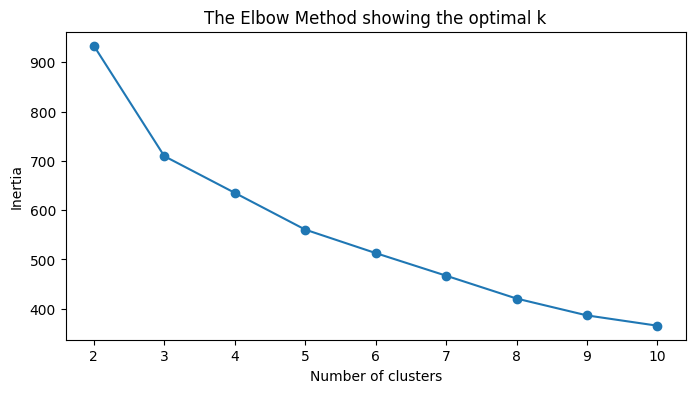

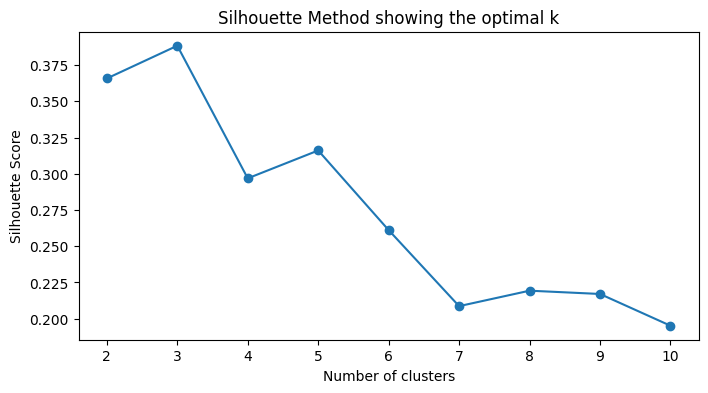

C:\Users\F\AppData\Local\Temp\ipykernel_17792\3863212026.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resampled_features_filtered['cluster'] = kmeans.labels_


In [424]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# filter DataFrame
resampled_features_filtered = resampled_features_df[(resampled_features_df['duration'] > 1000) & (resampled_features_df['duration'] < 2000)]

# exclude 'child' column
features = resampled_features_filtered.drop('child', axis=1)

# scale data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# search for an optimal number of clusters, from 2 to 10
clusters_range = range(2, 11)
inertia = []
silhouette = []

for clusters in clusters_range:
    kmeans = KMeans(n_clusters=clusters, random_state=42).fit(features_scaled)
    inertia.append(kmeans.inertia_) # sum of squared distances to closest centroid
    silhouette.append(silhouette_score(features_scaled, kmeans.labels_))

# plot the inertia
plt.figure(figsize=(8, 4))
plt.plot(clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# plot the silhouette score
plt.figure(figsize=(8, 4))
plt.plot(clusters_range, silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method showing the optimal k')
plt.show()

# Now we can perform K-means clustering with the selected number of clusters
#optimal_clusters = clusters_range[silhouette.index(max(silhouette))] # choose the model with the highest silhouette score
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42).fit(features_scaled)
resampled_features_filtered['cluster'] = kmeans.labels_


In [425]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

def cluster_and_plot(df, n_clusters):
    # Exclude 'child' column
    features = df.drop('child', axis=1)

    # Scale data
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Fit k-means with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=57)
    kmeans.fit(features_scaled)

    # Apply PCA to reduce the dimensions
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features_scaled)

    # Create a DataFrame with the two principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    # Concatenate the clusters labels to the DataFrame
    pca_df = pd.concat([pca_df, pd.DataFrame({'Cluster':kmeans.labels_})], axis=1)

    # Plot the clustered data
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(f'2 component PCA with {n_clusters} clusters', fontsize = 20)
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
    clusters = list(range(n_clusters))
    for cluster, color in zip(clusters, colors[:n_clusters]):
        indicesToKeep = pca_df['Cluster'] == cluster
        ax.scatter(pca_df.loc[indicesToKeep, 'PC1'], pca_df.loc[indicesToKeep, 'PC2'], c=color, s=50)
    ax.legend(clusters)
    ax.grid()
    plt.show()


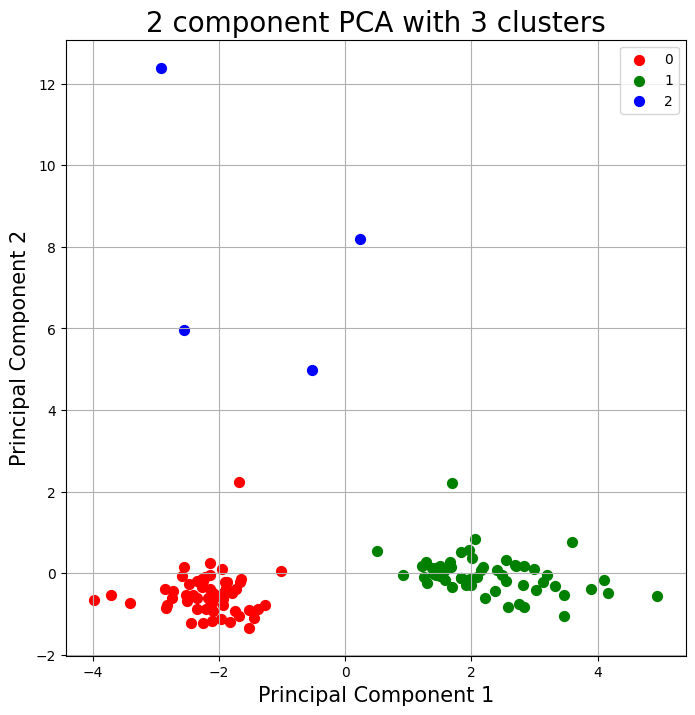

In [427]:
cluster_and_plot(resampled_features_filtered, 3)

In [432]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import silhouette_score

# Compute silhouette score before permutation
original_score = silhouette_score(features_scaled, kmeans.labels_)

# Initialize dictionary to hold permutation scores
importance_scores = {}

# Permute each feature one by one and calculate the new silhouette score
for column in features.columns:
    features_permuted = features.copy()
    features_permuted[column] = np.random.permutation(features_permuted[column])
    features_permuted_scaled = scaler.transform(features_permuted)
    permuted_clusters = kmeans.predict(features_permuted_scaled)
    permuted_score = silhouette_score(features_permuted_scaled, permuted_clusters)
    importance_scores[column] = original_score - permuted_score

# Print feature importances
for feature, importance in sorted(importance_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{feature}: {importance}")


offset_focus_score: 0.07106974105192171
frequency_focus_score: 0.0563608104765434
amplitude_focus_score: 0.055591562263865746
change_rate: 0.04112540543768073
total_changes: 0.039417332456014864
phase_biases_focus_score: 0.03542440740107616
change_persistence: 0.03240101745052576
change_volatility: 0.02876001476086837
std_change_rate: 0.025475639789983018
std_time_between_changes: 0.02472669921191739
average_time_between_changes: 0.02389116494526139
duration: 0.002063824905753353


In [433]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features.columns)

In [435]:
pd.options.display.float_format = '{:.4f}'.format
centroids_df


,total_changes,duration,change_rate,std_change_rate,average_time_between_changes,std_time_between_changes,change_persistence,change_volatility,frequency_focus_score,phase_biases_focus_score,amplitude_focus_score,offset_focus_score
0,99.2500,1501.0150,0.0615,37.5168,21.5387,150.8785,1.3826,0.2739,0.5975,0.1247,0.2717,0.0762
1,2560.0862,1324.3105,1.9438,25.5378,0.6115,5.9405,1.0085,0.1260,0.1814,0.0971,0.3155,0.4080
2,759.7241,1324.3105,0.5820,19.3228,2.3959,11.6555,4.1438,0.1820,0.5632,0.3172,0.0618,0.0652


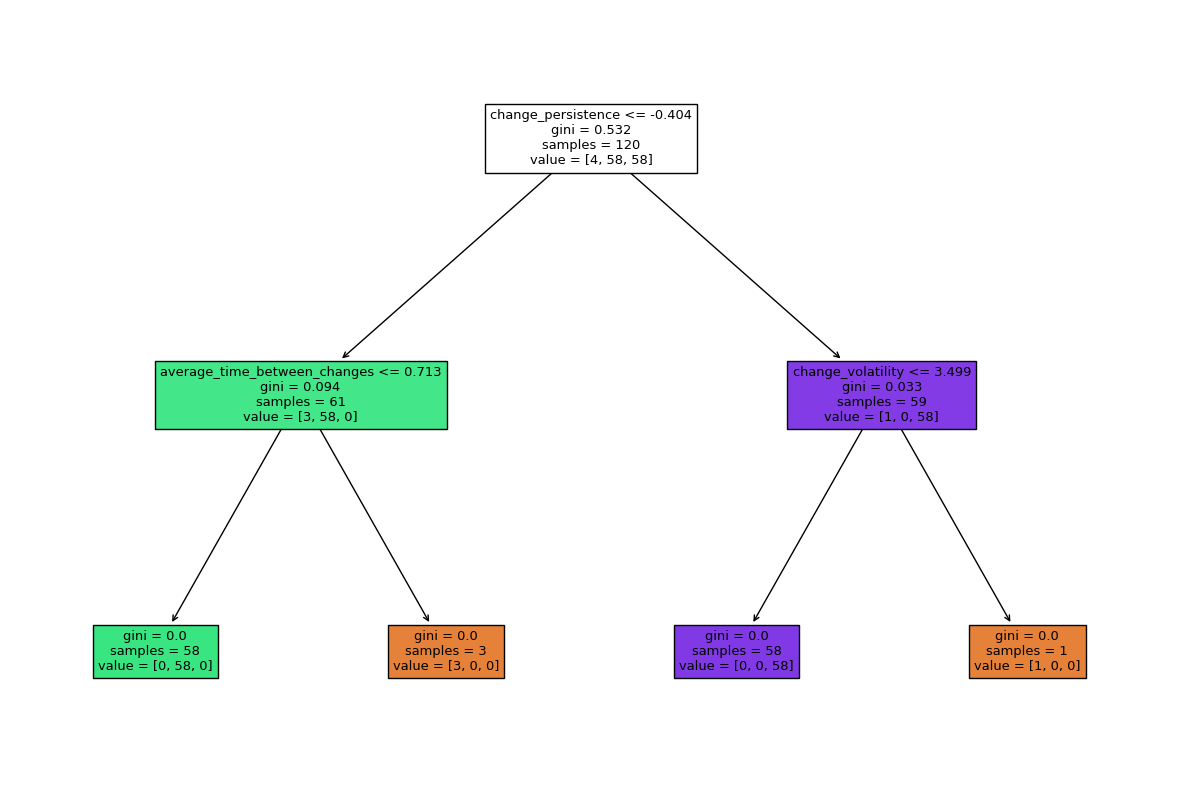

In [436]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Fit a decision tree to the scaled features and cluster labels
dt = DecisionTreeClassifier(max_depth=3)  # adjust max_depth to suit your needs
dt.fit(features_scaled, kmeans.labels_)

# Plot the decision tree
plt.figure(figsize=(15,10))
plot_tree(dt, filled=True, feature_names=features.columns)
plt.show()


In [438]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_components = pd.DataFrame(pca.components_, columns=features.columns, index=['PC1', 'PC2'])
pca_components


,total_changes,duration,change_rate,std_change_rate,average_time_between_changes,std_time_between_changes,change_persistence,change_volatility,frequency_focus_score,phase_biases_focus_score,amplitude_focus_score,offset_focus_score
PC1,-0.3976,0.0102,-0.4000,-0.1698,0.2174,0.1823,0.2945,0.2885,0.3287,0.2474,-0.3156,-0.3656
PC2,-0.0086,0.0387,-0.0145,0.4635,0.5161,0.5478,-0.2125,0.2381,-0.0046,-0.2198,0.2560,0.0341


In [365]:
resampled_features_filtered[resampled_features_filtered['cluster']==2]

,child,total_changes,duration,change_rate,std_change_rate,average_time_between_changes,std_time_between_changes,change_persistence,change_volatility,frequency_focus_score,phase_biases_focus_score,amplitude_focus_score,offset_focus_score,cluster
140,16-05-2023 14-38-37 TestDean160520231 2 modules_1,191,1719.148,0.111102,31.811808,8.998806,110.740490,1.015707,7.273783,0.434555,0.178010,0.230366,0.178010,2
141,16-05-2023 14-38-37 TestDean160520231 2 modules_2,129,1719.148,0.075037,23.553361,13.427906,134.837710,1.511628,13.335251,0.643411,0.263566,0.054264,0.069767,2
150,17-04-2023 10-33-29 107 2 modules_1,50,1282.882,0.038975,46.859131,22.346180,151.674614,1.040000,0.978074,0.460000,0.020000,0.580000,0.020000,2
151,17-04-2023 10-33-29 107 2 modules_2,27,1282.882,0.021046,47.843077,41.381814,206.261023,1.962963,3.446785,0.851852,0.037037,0.222222,0.037037,2


In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates

def plot_time_series(index, str_val):
    # Get the DataFrame from the dictionary
    df_name = df_names_list[index] +'_'+ str_val
    df = resampled_dfs[df_name]

    # Ensure 'timestamp' is in the correct format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Standardize the data (excluding 'timestamp')
    scaler = StandardScaler()
    df[df.columns.difference(['timestamp'])] = scaler.fit_transform(df[df.columns.difference(['timestamp'])])

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Set the title for the figure
    plt.title(f'Standardized Time-Series Plots in session {index} for user {str_val}')

    # Define the offset
    offset = 0

    # Manually specify the order of the columns
    cols = ['frequency', 'phase_biases', 'amplitude', 'offset']

    # Plot each column
    for col in cols:
        if col in df.columns:
            # plot the line with an offset
            plt.plot(df['timestamp'], df[col] + offset, label=col, alpha=0.7)

            # Add annotation with the feature name
            plt.text(df['timestamp'].min() - pd.Timedelta(minutes=1), offset, col, fontsize=10, ha='right')

            # Increase the offset for the next line
            offset += 14

    # Set labels
    plt.xlabel('Time')
    
    # Remove y axis labels
    ax.yaxis.set_visible(False)

    # Format x axis to show minutes and seconds
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    # Display the plot without the legend
    plt.show()

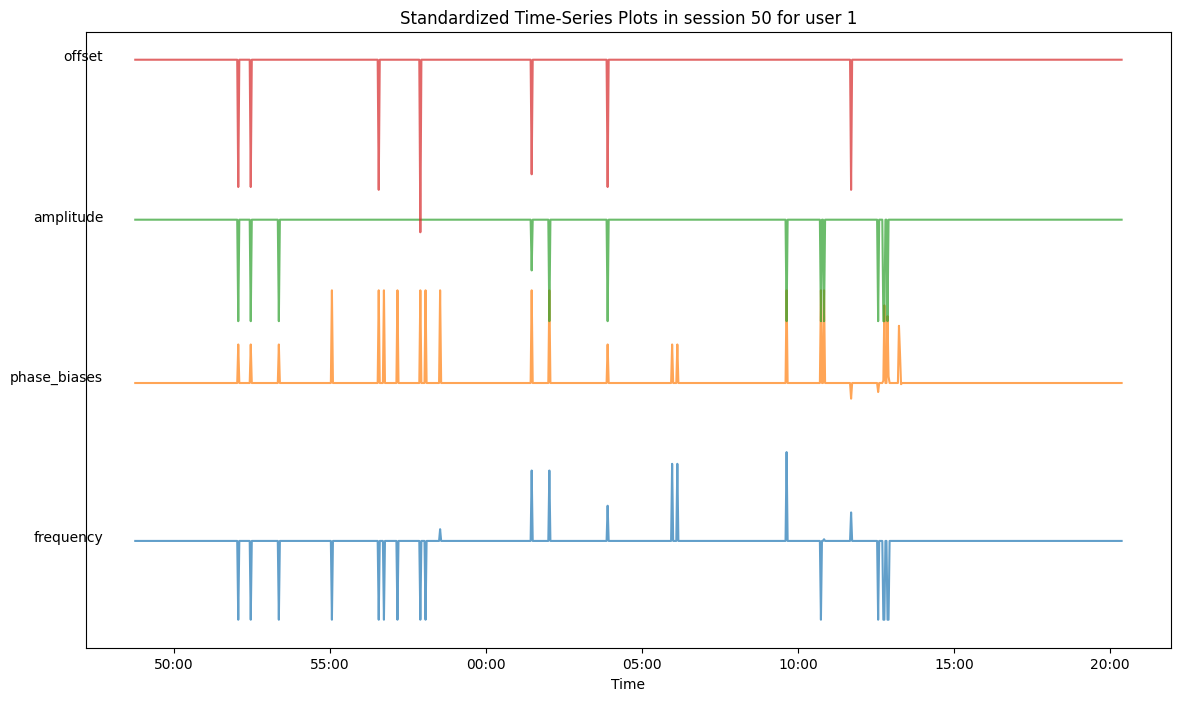

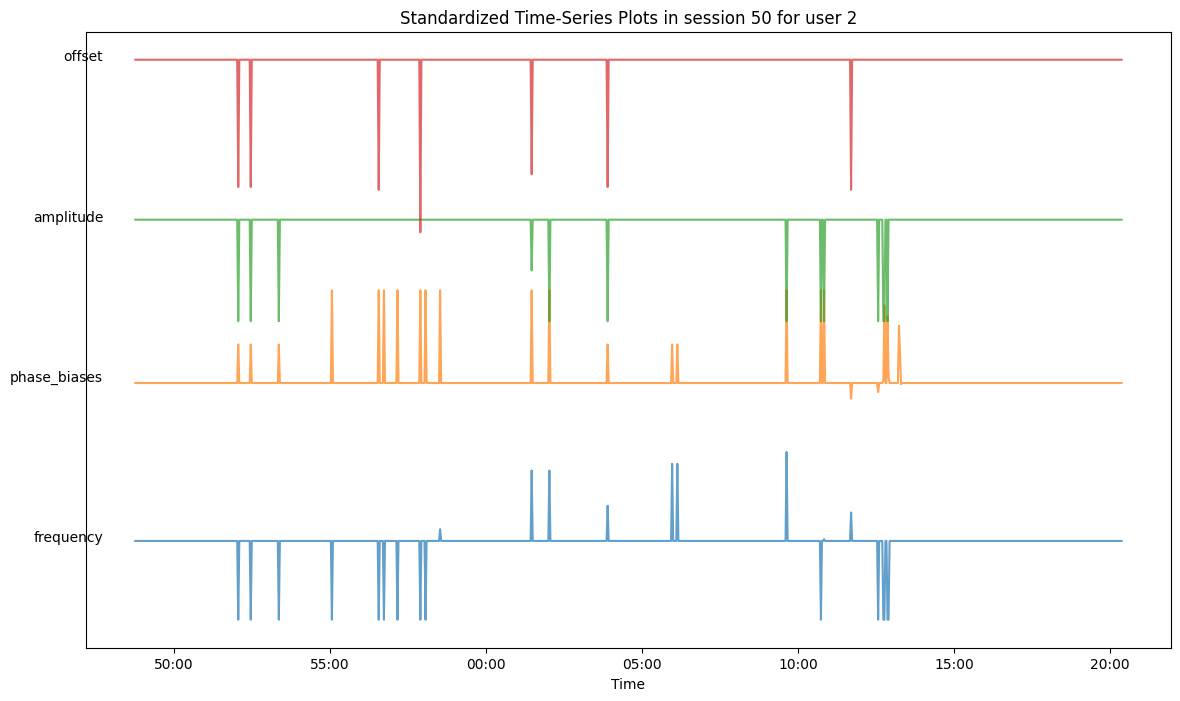

In [367]:
plot_time_series(50, '1')
plot_time_series(50, '2')

In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_time_series_events(index, str_val):
    # Get the DataFrame from the dictionary
    df_name = df_names_list[index] +'_'+ str_val
    df = resampled_dfs[df_name]

    # Ensure 'timestamp' is in the correct format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))

    # Set the title for the figure
    plt.title(f'Event Plots for Changes in session {index} for user {str_val}')

    # Define the offset
    offset = 0

    # Manually specify the order of the columns
    cols = ['frequency', 'phase_biases', 'amplitude', 'offset','angles']

    # For each column
    for col in cols:
        if col in df.columns:
            # Identify where changes occur
            changes = df[col].diff().ne(0)
            
            # Plot a vertical line whenever a change occurs
            plt.vlines(x=df.loc[changes, 'timestamp'], ymin=offset, ymax=offset + 1, label=col)
            
            # Add annotation with the feature name
            plt.text(df['timestamp'].min() - pd.Timedelta(minutes=1), offset + 0.5, col, fontsize=10, ha='right')
            
            # Increase the offset for the next line
            offset += 2

    # Remove y axis labels
    ax.yaxis.set_visible(False)

    # Format x axis to show minutes and seconds
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    # Set labels
    plt.xlabel('Time')

    # Display the plot without the legend
    plt.show()

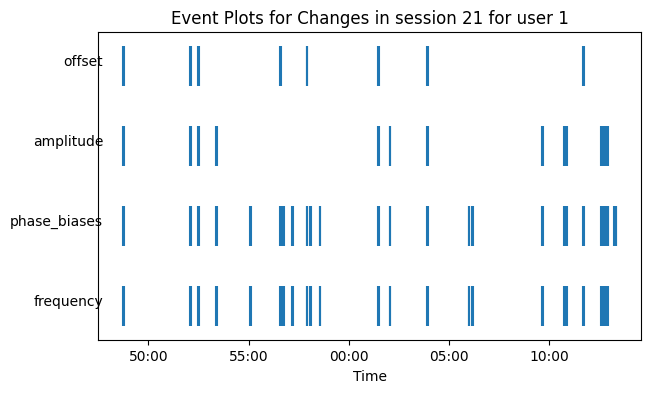

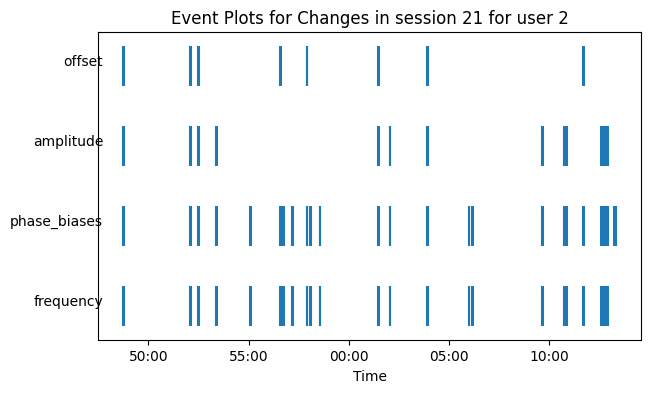

In [394]:
plot_time_series_events(21, '1')
plot_time_series_events(21, '2')

In [368]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

def plot_parameters(position, df_list, df_dict):
    df_name = df_list[position]
    df = df_dict[df_name]

    # Convert 'timestamp' to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    scaler = StandardScaler()
    df[df.columns.difference(['timestamp'])] = scaler.fit_transform(df[df.columns.difference(['timestamp'])])
    parameters = ['frequency', 'phase_biases', 'amplitude', 'offset', 'angle', 'potentials']

    # Convert all parameters to numeric
    for parameter in parameters:
        if parameter in ['frequency', 'phase_biases']:
            df[parameter] = pd.to_numeric(df[parameter], errors='coerce')
        else:
            df[parameter+'_1'] = pd.to_numeric(df[parameter+'_1'], errors='coerce')
            df[parameter+'_2'] = pd.to_numeric(df[parameter+'_2'], errors='coerce')

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Set the title for the figure
    plt.title(f'Standardized Time-Series Plots for session {position}')

    # Define the offset
    offset = 0

    # Manually specify the order of the columns
    cols = ['frequency', 'phase_biases', 'amplitude_1', 'amplitude_2', 'offset_1', 'offset_2']

    # Plot each column
    for col in cols:
        if col in df.columns:
            # plot the line with an offset
            plt.plot(df['timestamp'], df[col] + offset, label=col, alpha=0.7)

            # Add annotation with the feature name
            plt.text(df['timestamp'].min() - pd.Timedelta(minutes=1), offset, col, fontsize=10, ha='right')

            # Increase the offset for the next line
            offset += 12 
    # Set labels
    plt.xlabel('Time')
    
    # Remove y axis labels
    ax.yaxis.set_visible(False)

    # Format x axis to show minutes and seconds
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    # Display the plot without the legend
    plt.show()


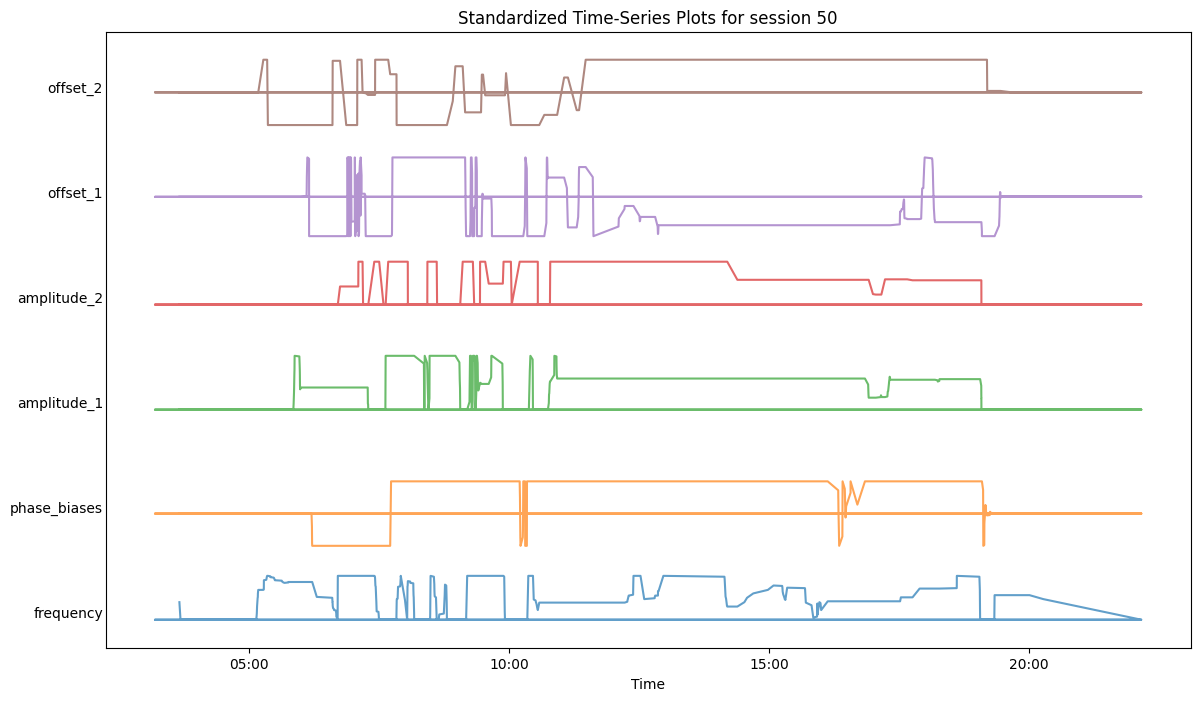

In [369]:
plot_parameters(50, df_names_list, params_oscills_dfs)

In [373]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_time_series_events(index):
    # Get the DataFrame from the dictionary
    df_name = df_names_list[index]
    df = params_oscills_dfs[df_name]

    # Ensure 'timestamp' is in the correct format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Convert column values to numeric if possible
    numeric_cols = ['frequency', 'phase_biases', 'amplitude_1', 'amplitude_2', 'offset_1', 'offset_2']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='ignore')

    # Calculate time difference in seconds from the minimum timestamp
    df['time_passed'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))

    # Set the title for the figure
    plt.title(f'Event Plots for Changes in session {index}')

    # Define the offset
    offset = 0

    # Manually specify the order of the columns
    cols = ['frequency', 'phase_biases', 'amplitude_1', 'amplitude_2', 'offset_1', 'offset_2']

    # For each column
    for col in cols:
        if col in df.columns:
            # Identify where changes occur
            changes = df[col].diff().ne(0)

            # Plot a vertical line whenever a change occurs
            plt.vlines(x=df.loc[changes, 'time_passed'], ymin=offset, ymax=offset + 1, label=col)

            # Add annotation with the feature name
            plt.text(df['time_passed'].min() - 20, offset + 0.5, col, fontsize=10, ha='right', va='center')

            # Increase the offset for the next line
            offset += 2

    # Remove y axis labels
    ax.yaxis.set_visible(False)

    # Set x-axis limits based on data range with a buffer of 0.5 seconds
    ax.set_xlim(-15, df['time_passed'].max() + 15)

    # Format x axis to show minutes and seconds
    formatter = FuncFormatter(lambda x, pos: f'{int(x//60):02d}:{int(x%60):02d}')
    ax.xaxis.set_major_formatter(formatter)

    # Set labels
    plt.xlabel('Time Passed (minutes:seconds)')

    # Display the plot without the legend
    plt.show()


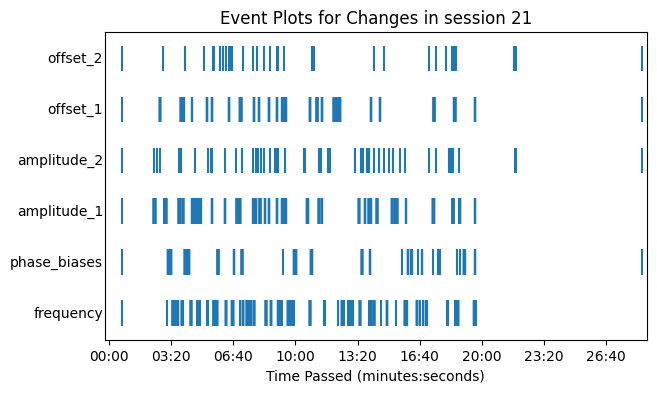

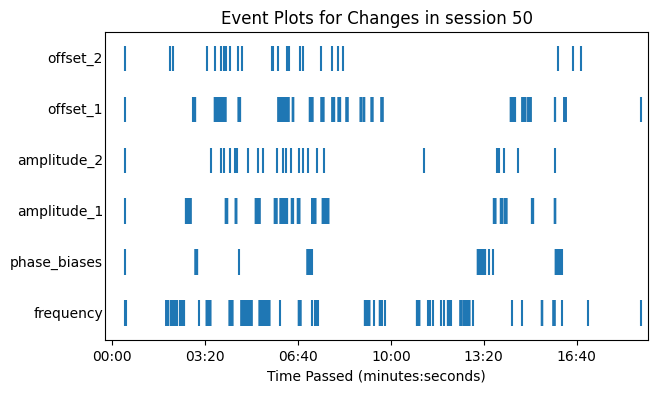

In [390]:
plot_time_series_events(21)
plot_time_series_events(50)